In [3]:
# ---------- 0) IMPORTS ----------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os
from scipy.stats import binom, poisson, norm
sns.set_theme()
plt.rcParams["figure.figsize"] = (7,4)
pd.set_option("display.max_columns", 100)

In [4]:
# ============================================================
# PHẦN A — TẠO DỮ LIỆU GIẢ LẬP (nếu bạn không có file gốc)
# ============================================================
# Ý tưởng: sinh dữ liệu giống Gapminder thu nhỏ:
# - 4 khu vực (region): Europe, Asia, Africa, Americas
# - 24 quốc gia (6/quốc gia mỗi region)
# - Năm: 2000..2010 (11 năm) -> 24*11 = 264 dòng
# - life, gdp, fertility, child_mortality phụ thuộc theo region + nhiễu

np.random.seed(42)

regions = ["Europe", "Asia", "Africa", "Americas"]
countries_per_region = 6
years = list(range(2000, 2011))

# tạo tên quốc gia giả
def fake_country_list(region, k):
    return [f"{region[:2].upper()}_{i:02d}" for i in range(1, k+1)]

rows = []
for reg in regions:
    # baseline theo vùng (đặt “thật thật” một chút)
    if reg == "Europe":
        base_life, base_gdp, base_fert, base_cm = 78, 35000, 1.6, 5
    elif reg == "Asia":
        base_life, base_gdp, base_fert, base_cm = 73, 18000, 2.1, 15
    elif reg == "Africa":
        base_life, base_gdp, base_fert, base_cm = 62, 5000, 3.8, 60
    else:  # Americas
        base_life, base_gdp, base_fert, base_cm = 75, 28000, 2.0, 10

    countries = fake_country_list(reg, countries_per_region)
    for c in countries:
        # mỗi nước lệch 1 chút so với base
        n_shift_life = np.random.normal(0, 1.2)
        n_shift_gdp  = np.random.normal(0, 2000)
        n_shift_fert = np.random.normal(0, 0.15)
        n_shift_cm   = np.random.normal(0, 3)

        for y in years:
            # xu hướng theo thời gian (nhẹ)
            t = y - years[0]
            life = base_life + n_shift_life + 0.05*t + np.random.normal(0, 1.0)
            gdp  = base_gdp  + n_shift_gdp  + 150*t   + np.random.normal(0, 1500)
            fert = max(0.8, base_fert + n_shift_fert - 0.02*t + np.random.normal(0, 0.08))
            cm   = max(1.0, base_cm   + n_shift_cm   - 0.8*t  + np.random.normal(0, 1.5))

            rows.append([y, c, reg, gdp, life, fert, cm])

df = pd.DataFrame(rows, columns=["Year","country","region","gdp","life","fertility","child_mortality"])


In [6]:
# Cố tình đưa một ít missing để test xử lý thiếu
mask = np.random.choice([True, False], size=len(df), p=[0.06, 0.94])
df.loc[mask, "gdp"] = np.nan
mask2 = np.random.choice([True, False], size=len(df), p=[0.04, 0.96])
df.loc[mask2, "life"] = np.nan

# Lưu file “giả” cho yên tâm
DATA_PATH = "synthetic_gapminder.csv"
df.to_csv(DATA_PATH, index=False)
print("✅ Đã tạo dữ liệu giả:", DATA_PATH)
display(df.head())
print("Shape:", df.shape)
print("Thiếu dữ liệu mỗi cột:"); display(df.isna().sum())

✅ Đã tạo dữ liệu giả: synthetic_gapminder.csv


,Year,country,region,gdp,life,fertility,child_mortality
0,2000,EU_01,Europe,NaN,78.361904,1.823490,10.720242
1,2001,EU_01,Europe,35687.311463,78.176583,1.640080,8.070495
2,2002,EU_01,Europe,32153.551031,78.938019,1.519160,7.125658
3,2003,EU_01,Europe,35644.842397,77.733226,1.564511,5.050634
4,2004,EU_01,Europe,34984.806947,80.261706,1.622556,4.231967


Shape: (264, 7)
Thiếu dữ liệu mỗi cột:


Year                0
country             0
region              0
gdp                22
life               24
fertility           0
child_mortality     0
dtype: int64

**===============================================================================**


# PHẦN 1 – EDA (Exploratory Data Analysis)
**============================================================**


In [8]:
# 1) Định tính / Định lượng
qual_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
quant_cols = df.select_dtypes(include=["number"]).columns.tolist()
print("\n Định tính:", qual_cols)
print(" Định lượng:", quant_cols)


 Định tính: ['country', 'region']
 Định lượng: ['Year', 'gdp', 'life', 'fertility', 'child_mortality']


In [9]:
# 2) Xử lý trùng/thiếu
dup_count = df.duplicated().sum()
print("\n Số dòng trùng lặp:", dup_count)
df_clean = df.drop_duplicates().copy()
# Điền thiếu: số -> mean; định tính -> mode
df_clean[quant_cols] = df_clean[quant_cols].apply(lambda s: s.fillna(s.mean()))
for c in qual_cols:
    if df_clean[c].isna().any():
        mv = df_clean[c].mode(dropna=True)
        df_clean[c] = df_clean[c].fillna(mv[0] if len(mv) else "UNKNOWN")
print("Đã xử lý thiếu & trùng. Shape:", df_clean.shape)
print("Thiếu dữ liệu (mới):"); display(df_clean.isna().sum())



 Số dòng trùng lặp: 0
Đã xử lý thiếu & trùng. Shape: (264, 7)
Thiếu dữ liệu (mới):


Year               0
country            0
region             0
gdp                0
life               0
fertility          0
child_mortality    0
dtype: int64

In [10]:
# 3) Thống kê mô tả
desc = df_clean[quant_cols].agg(["mean","median","std","min","max",
                                 lambda s:s.quantile(0.25),
                                 lambda s:s.quantile(0.75)]).T
desc.columns = ["mean","median","std","min","max","q25","q75"]
print("\n Thống kê mô tả các cột số:"); display(desc)



 Thống kê mô tả các cột số:


,mean,median,std,min,max,q25,q75
Year,2005.000000,2005.000000,3.168284,2000.000000,2010.000000,2002.000000,2008.000000
gdp,21776.767169,21776.767169,10906.677346,-674.212192,39793.946859,15043.143605,31690.162778
life,72.546942,73.932218,5.919578,59.906845,80.871571,71.576701,77.117208
fertility,2.279391,2.019978,0.808444,1.168786,3.996254,1.702911,2.615358
child_mortality,19.189326,8.490803,22.275867,1.000000,66.837301,3.884330,28.045858


**4) Histogram, Boxplot, Bar, Pie, Heatmap, Pairplot**

In [12]:
#Chọn vài cột số nổi bật để vẽ
candidates = ["gdp","life","fertility","child_mortality"]
candidates = [c for c in candidates if c in df_clean.columns][:4] or quant_cols[:4]
print("\n Vẽ cho các cột:", candidates)



 Vẽ cho các cột: ['gdp', 'life', 'fertility', 'child_mortality']


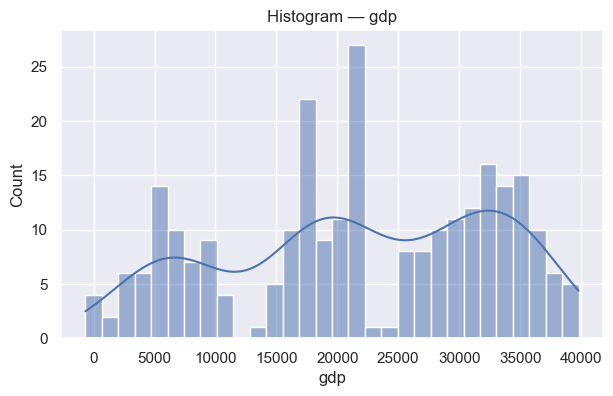

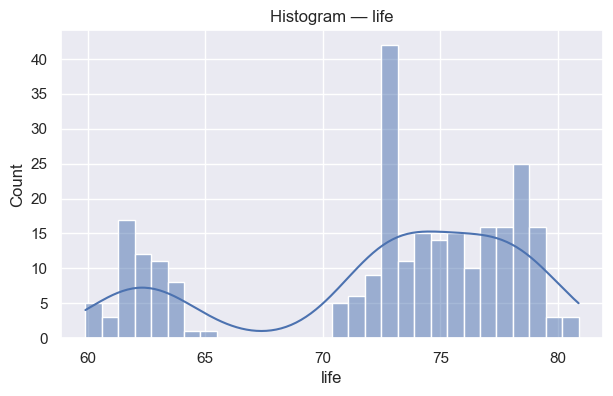

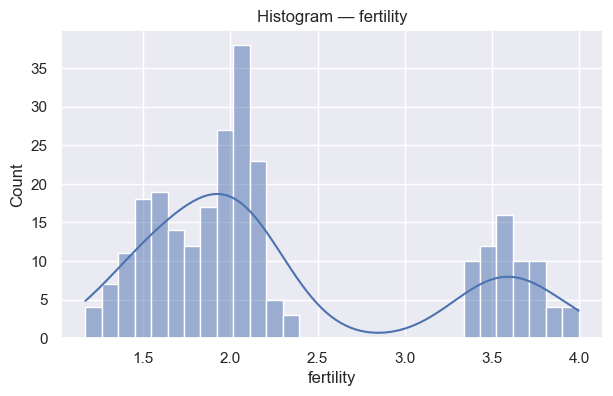

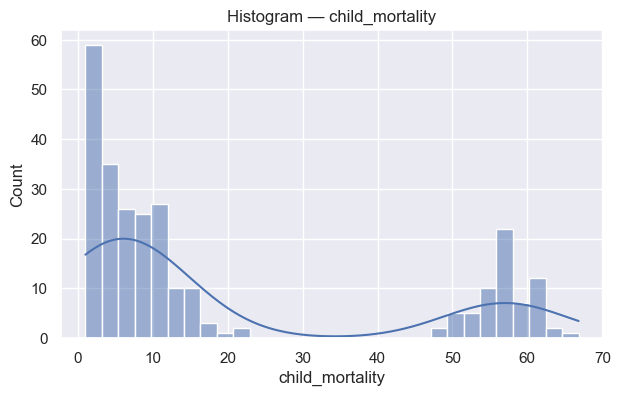

In [13]:
# Histogram
for col in candidates:
    plt.figure()
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f"Histogram — {col}")
    plt.show()

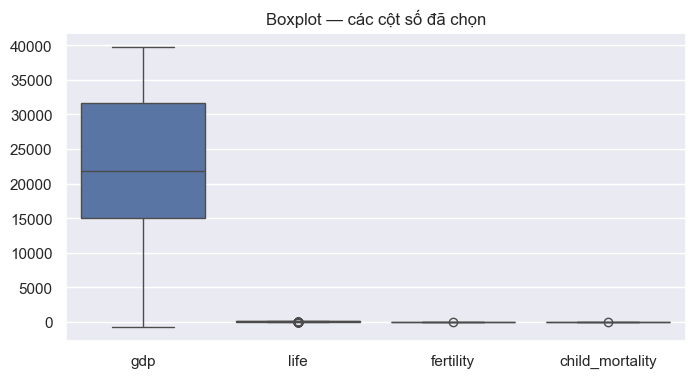

In [14]:
# Boxplot (multi)
plt.figure(figsize=(8,4))
sns.boxplot(data=df_clean[candidates])
plt.title("Boxplot — các cột số đã chọn")
plt.show()

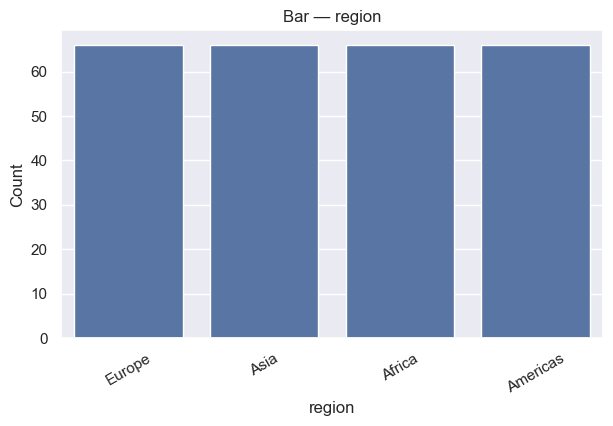

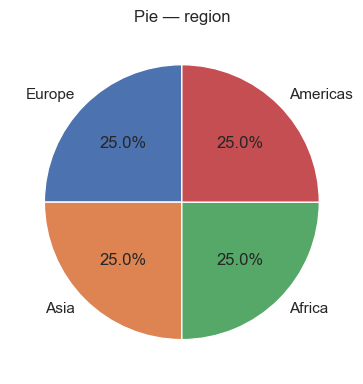

In [15]:
# Bar & Pie cho cột định tính đại diện
cat_col = "region" if "region" in df_clean.columns else (qual_cols[0] if qual_cols else None)
if cat_col:
    vc = df_clean[cat_col].value_counts()
    plt.figure()
    sns.barplot(x=vc.index, y=vc.values)
    plt.title(f"Bar — {cat_col}"); plt.xticks(rotation=30); plt.ylabel("Count"); plt.show()

    plt.figure()
    plt.pie(vc.values, labels=vc.index, autopct="%1.1f%%", startangle=90)
    plt.title(f"Pie — {cat_col}"); plt.tight_layout(); plt.show()


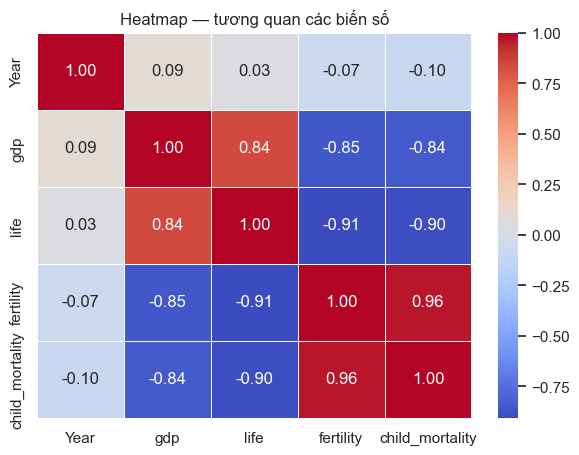

In [16]:
# Heatmap tương quan
plt.figure(figsize=(7,5))
sns.heatmap(df_clean[quant_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.4)
plt.title("Heatmap — tương quan các biến số")
plt.show()

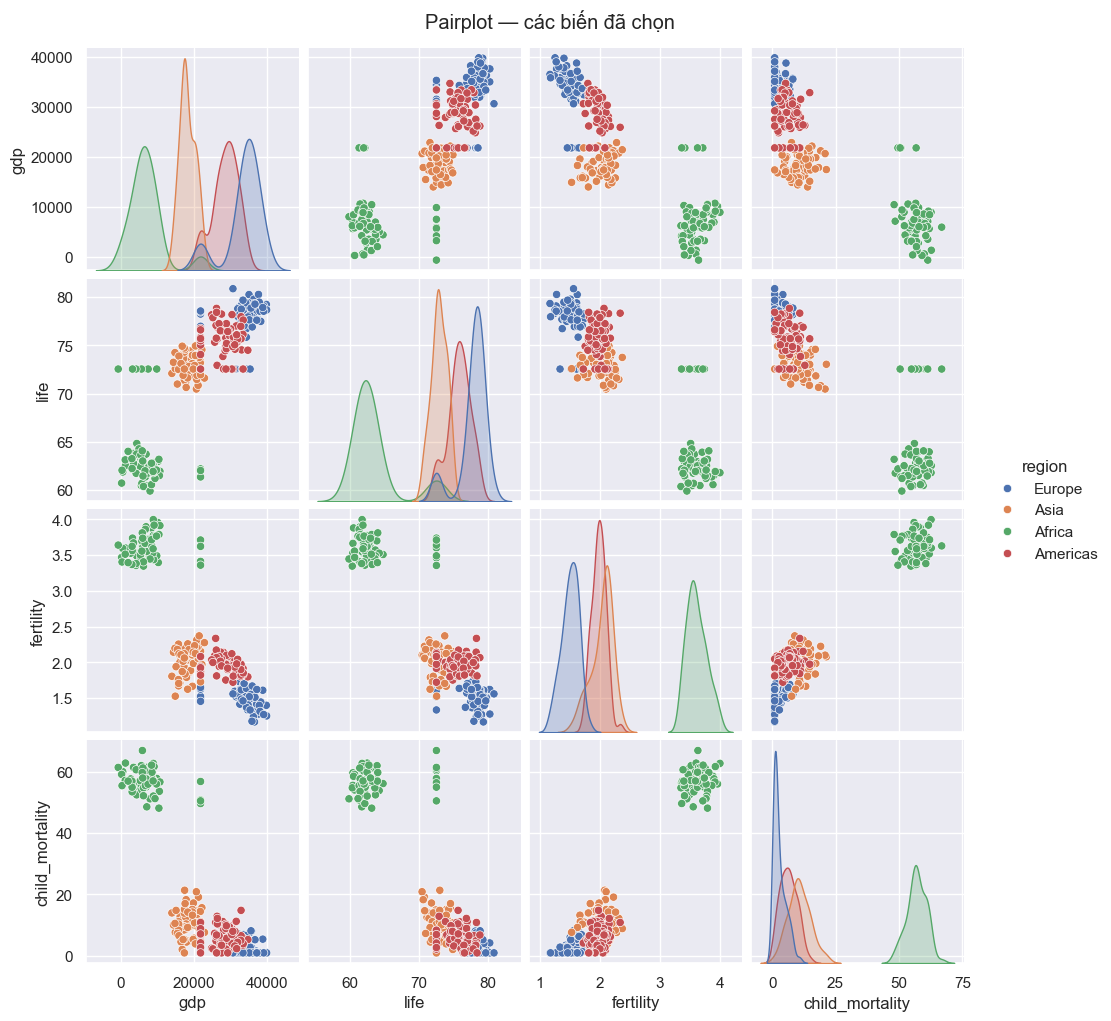

In [17]:
# Pairplot (giới hạn nếu nhiều dòng)
pp_cols = candidates
df_pp = df_clean.sample(1200, random_state=1) if len(df_clean) > 1200 else df_clean.copy()
sns.pairplot(df_pp, vars=pp_cols, hue=cat_col if cat_col else None, diag_kind="kde")
plt.suptitle("Pairplot — các biến đã chọn", y=1.02)
plt.show()


 Groupby theo: region


gdp                                        life             \
                  mean        median          std count       mean     median   
region                                                                          
Africa     6981.007738   6141.693842  4678.095958    66  63.567008  62.482169   
Americas  28444.585134  28818.246711  3409.102558    66  75.816954  75.815706   
Asia      18189.682673  17689.078371  2112.974722    66  72.908294  72.935967   
Europe    33491.793130  34809.530813  4847.359496    66  77.895513  78.324526   

                         fertility                           child_mortality  \
               std count      mean    median       std count            mean   
region                                                                         
Africa    3.513913    66  3.605137  3.579478  0.163083    66       56.914701   
Americas  1.607955    66  1.978188  1.975855  0.115371    66        6.404523   
Asia      1.117306    66  2.031740  2.090124  0.180836    66       10.636820   
Europe    1.919435    66  1.502499  1.519633  0.141421    66        2.801258   

                                     
             median       std count  
region                               
Africa    56.883125  3.798232    66  
Americas   6.399817  3.302124    66  
Asia      10.367551  4.330603    66  
Europe     1.505178  2.374434    66

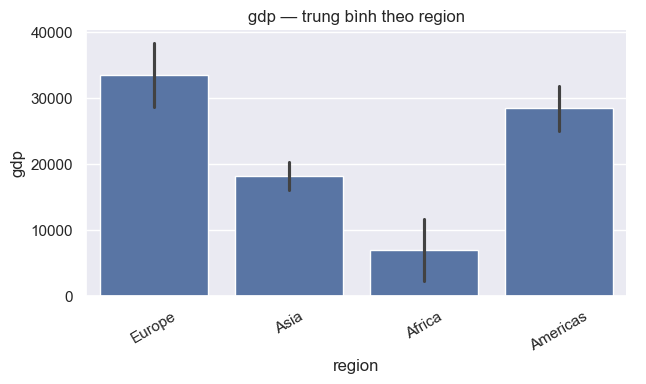

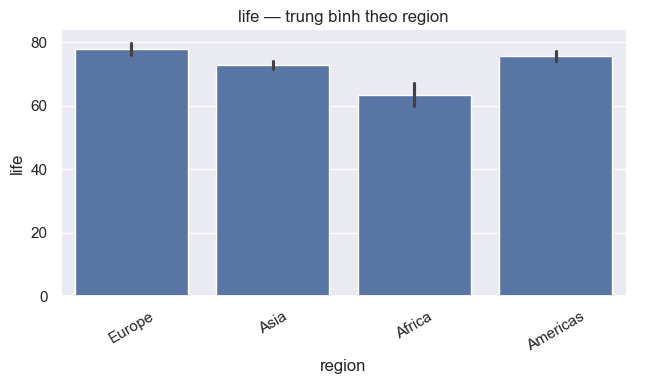

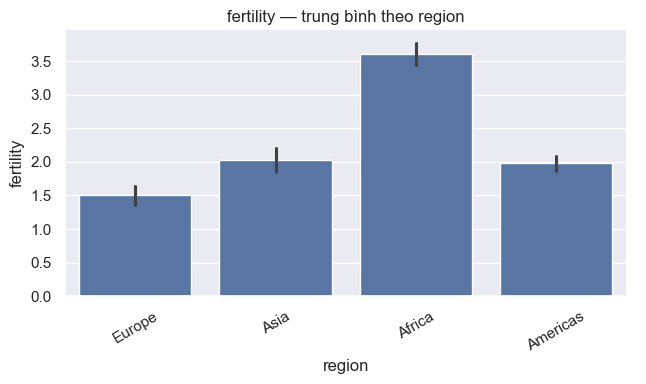

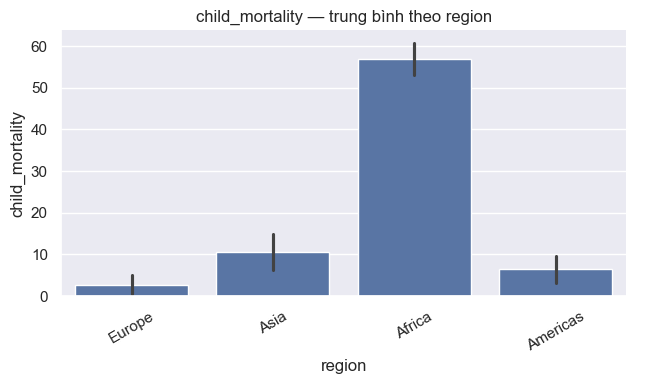

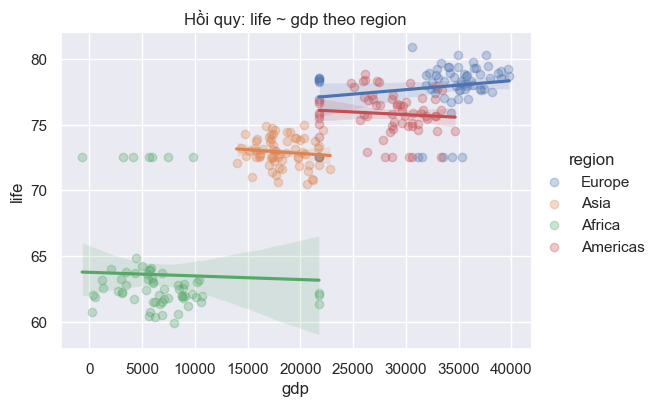

In [25]:
# 5) Groupby theo nhóm (region) + so sánh
group_col = "region" if "region" in df_clean.columns else (cat_col if cat_col else None)
print("\n Groupby theo:", group_col)

if group_col:
    gstat = df_clean.groupby(group_col)[candidates].agg(["mean","median","std","count"])
    display(gstat)

    # catplot: bar mean theo nhóm (FIX: seaborn >= 0.13 dùng errorbar='sd')
    for col in candidates:
        try:
            ax = sns.catplot(
                data=df_clean, x=group_col, y=col,
                kind="bar", errorbar="sd", height=4, aspect=1.6
            )
        except TypeError:
            # fallback cho seaborn cũ (ci='sd' còn hoạt động)
            ax = sns.catplot(
                data=df_clean, x=group_col, y=col,
                kind="bar", ci="sd", height=4, aspect=1.6
            )
        plt.title(f"{col} — trung bình theo {group_col}")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

    # lmplot: ví dụ life ~ gdp theo region
    if {"life", "gdp"}.issubset(df_clean.columns):
        sns.lmplot(
            data=df_clean, x="gdp", y="life",
            hue=group_col, scatter_kws={"alpha":0.3},
            height=4, aspect=1.4
        )
        plt.title(f"Hồi quy: life ~ gdp theo {group_col}")
        plt.show()



**============================================================**
# PHẦN 2 – Thống kê và xác suất.
**============================================================**


In [19]:
# Binomial: dùng p̂ = P(life > median(life)) nếu có cột life
if "life" in df_clean.columns:
    thr = df_clean["life"].median()
    p_hat = (df_clean["life"] > thr).mean()
    n, k = 30, 10
    p_ge_k = 1 - binom.cdf(k-1, n, p_hat)
    print(f"\n🧪 Binomial — p̂=P(life>{thr:.2f})={p_hat:.3f}, n={n}, k={k} ⇒ P(X≥{k})={p_ge_k:.4f}")
else:
    print("\n🧪 Binomial — không có cột 'life', bỏ qua ví dụ này.")



🧪 Binomial — p̂=P(life>73.93)=0.500, n=30, k=10 ⇒ P(X≥10)=0.9786


In [20]:
# Poisson: ví dụ “≤ 3 lỗi/km vải” với λ=2.5 (giả định)
lam = 2.5
p_le_3 = poisson.cdf(3, lam)
print(f"🧪 Poisson — λ={lam:.2f}, P(X ≤ 3) = {p_le_3:.4f}")


🧪 Poisson — λ=2.50, P(X ≤ 3) = 0.7576


In [21]:
# Normal: dùng 1 cột số đại diện (life nếu có, không thì gdp)
norm_col = "life" if "life" in df_clean.columns else (candidates[0] if candidates else quant_cols[0])
mu  = df_clean[norm_col].mean()
sd  = df_clean[norm_col].std(ddof=1)
a   = mu  # ví dụ P(X < mean)
p_lt_a = norm.cdf(a, mu, sd)
q95 = norm.ppf(0.95, mu, sd)
print(f"🧪 Normal — biến: {norm_col}, μ={mu:.3f}, σ={sd:.3f} ⇒ P(X<{a:.2f})={p_lt_a:.4f},  phân vị 95%={q95:.3f}")


🧪 Normal — biến: life, μ=72.547, σ=5.920 ⇒ P(X<72.55)=0.5000,  phân vị 95%=82.284


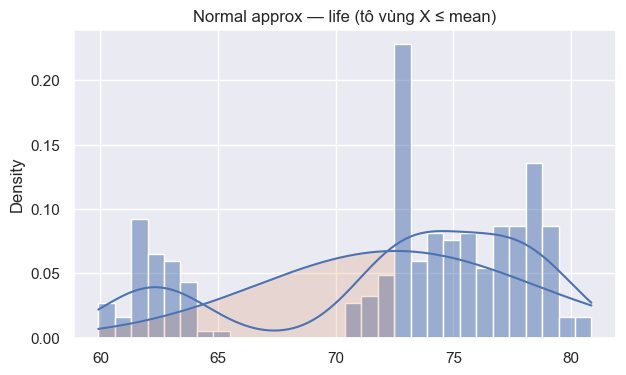

In [22]:
# Vẽ minh họa Normal
x = df_clean[norm_col].dropna().values
plt.figure()
sns.histplot(x, kde=True, stat="density", bins=30)
xs = np.linspace(x.min(), x.max(), 400)
ys = norm.pdf(xs, mu, sd)
plt.plot(xs, ys)
plt.fill_between(xs, 0, ys, where=(xs<=a), alpha=0.2)
plt.title(f"Normal approx — {norm_col} (tô vùng X ≤ mean)")
plt.show()

**============================================================**
# PHẦN 3 – NHẬN XÉT TỰ LUẬN (điền trực tiếp trong notebook)
**=============================================================**

In [23]:
print("\n================= GỢI Ý VIẾT TỰ LUẬN =================")
print("- Histogram/Boxplot: biến nào lệch phải (skewed right) hoặc lệch trái?")
print("- Heatmap/Pairplot: gdp và life có tương quan dương rõ (đường xu hướng đi lên)?")
print("- Nhóm (region) nào có life trung bình cao nhất/child_mortality thấp nhất?")
print("- Với Binomial: tỉ lệ vượt ngưỡng (life > median) có lớn không? So sánh p̂ với trực giác.")
print("- Với Poisson: λ=2.5 có hợp bối cảnh? (sự kiện hiếm, độc lập).")
print("- Với Normal: phân vị 95% cho biết ngưỡng “top 5%” của biến như thế nào.")
print("=======================================================")


================= GỢI Ý VIẾT TỰ LUẬN =================
- Histogram/Boxplot: biến nào lệch phải (skewed right) hoặc lệch trái?
- Heatmap/Pairplot: gdp và life có tương quan dương rõ (đường xu hướng đi lên)?
- Nhóm (region) nào có life trung bình cao nhất/child_mortality thấp nhất?
- Với Binomial: tỉ lệ vượt ngưỡng (life > median) có lớn không? So sánh p̂ với trực giác.
- Với Poisson: λ=2.5 có hợp bối cảnh? (sự kiện hiếm, độc lập).
- Với Normal: phân vị 95% cho biết ngưỡng “top 5%” của biến như thế nào.
